In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random
from glob import glob
from tqdm import tqdm
from scipy.io import loadmat

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [45]:
data_dir = "/media/mountHDD2/khoibaocon"
data_seg_dir = "/media/mountHDD2/thao/Segmentation"
data_seg = os.listdir(data_seg_dir)

In [25]:
main_df = pd.read_csv(data_dir + "/Label.csv")
main_df.shape

(6877, 4)

In [26]:
main_df.head()

,Recording,First_label,Second_label,Third_label
0,A0001,5,NaN,NaN
1,A0002,1,NaN,NaN
2,A0003,2,NaN,NaN
3,A0004,2,NaN,NaN
4,A0005,7,NaN,NaN


In [27]:
main_df["First_label"].value_counts()

First_label
5    1695
2    1098
1     918
8     826
3     704
7     653
6     574
4     207
9     202
Name: count, dtype: int64

In [28]:
main_df["Second_label"].value_counts()

Second_label
5.0    162
2.0    123
7.0     47
6.0     42
8.0     41
4.0     28
3.0     18
9.0     16
Name: count, dtype: int64

In [29]:
main_df["Third_label"].value_counts()

Third_label
9.0    2
8.0    2
6.0    1
4.0    1
Name: count, dtype: int64

In [30]:
single_main_df = main_df[main_df["Second_label"].isnull()]
single_main_df.shape

(6400, 4)

In [31]:
# single_main_df.to_csv(data_dir + "/single_label.csv")

In [32]:
mat_files = glob(data_dir + "/alldata/*")
print(len(mat_files))

6877


In [33]:
single_fns = single_main_df["Recording"].values.tolist()
print(len(single_fns))

6400


In [34]:
single_mat_paths = [data_dir + f"/alldata/{x}.mat" for x in single_fns]
print(os.path.exists(single_mat_paths[0]))

True


In [49]:
data_seg_direct = [data_seg_dir + f"/{x}" for x in data_seg]

In [50]:
print(data_seg_direct)

['/media/mountHDD2/thao/Segmentation/A3070_seg2.mat', '/media/mountHDD2/thao/Segmentation/A1024_seg1.mat', '/media/mountHDD2/thao/Segmentation/A2812_seg2.mat', '/media/mountHDD2/thao/Segmentation/A4717_seg3.mat', '/media/mountHDD2/thao/Segmentation/A4973_seg2.mat', '/media/mountHDD2/thao/Segmentation/A2611_seg2.mat', '/media/mountHDD2/thao/Segmentation/A6686_seg1.mat', '/media/mountHDD2/thao/Segmentation/A6175_seg2.mat', '/media/mountHDD2/thao/Segmentation/A0587_seg4.mat', '/media/mountHDD2/thao/Segmentation/A6185_seg1.mat', '/media/mountHDD2/thao/Segmentation/A1361_seg2.mat', '/media/mountHDD2/thao/Segmentation/A4456_seg5.mat', '/media/mountHDD2/thao/Segmentation/A3170_seg4.mat', '/media/mountHDD2/thao/Segmentation/A4480_seg2.mat', '/media/mountHDD2/thao/Segmentation/A5946_seg1.mat', '/media/mountHDD2/thao/Segmentation/A0944_seg1.mat', '/media/mountHDD2/thao/Segmentation/A6238_seg3.mat', '/media/mountHDD2/thao/Segmentation/A1572_seg4.mat', '/media/mountHDD2/thao/Segmentation/A4798_seg

In [36]:
sample_data = loadmat(single_mat_paths[0])
sample_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECG'])

In [37]:
sample_signal_data = sample_data['ECG'][0][0][2]
sample_signal_data.shape

(12, 7500)

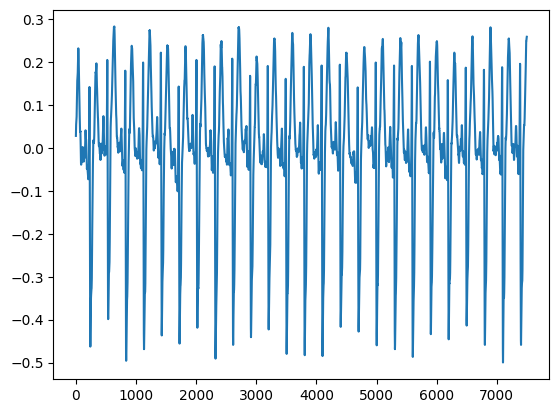

In [38]:
plt.plot(sample_signal_data[0])

In [39]:
class BasicBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.Conv1d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm1d(channel_num),
			nn.LeakyReLU(0.2),
		)
        self.conv_block2 = nn.Sequential(
			nn.Conv1d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm1d(channel_num),
		)
        self.relu = nn.LeakyReLU(0.2)
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [40]:
test_basic_block = BasicBlock(2)
sample_sig = torch.randn(1, 2, 32)
print(test_basic_block(sample_sig).shape)

torch.Size([1, 2, 32])


In [41]:
class ResNet(nn.Module):
    def __init__(self, in_channels = 12, type = 18, num_classes = 9):
        super(ResNet, self).__init__()
        self.struc_dict = {
            18: {
                "num_channels" : [64, 128, 256, 512],
                "counts" : [2, 2, 2, 2]
            }
        }
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.max1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.main = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                self.struc_dict[type]["num_channels"], 
                self.struc_dict[type]["counts"]
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.main.add_module(f"conv{idx+1}_{i}", BasicBlock(num_channel))
            if idx < len(self.struc_dict[type]["num_channels"]) - 1:
                self.main.add_module(f"ext_{idx}", nn.Conv1d(num_channel, self.struc_dict[type]["num_channels"][idx+1], 3, 1))
                self.main.add_module(f"extbn_{idx}", nn.BatchNorm1d(self.struc_dict[type]["num_channels"][idx+1]))
                                     
        self.avg = torch.nn.AdaptiveAvgPool1d((1))
        self.lin = nn.Linear(self.struc_dict[type]["num_channels"][-1], num_classes)
        torch.nn.init.kaiming_normal_(self.lin.weight)
    def forward(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.main(x)
        x = self.avg(x)
        x = x.reshape(x.shape[0], -1)
        x = self.lin(x)
        return x

In [42]:
model = ResNet()
sample_sig = torch.randn(1, 12, 3000)
model(sample_sig).shape

torch.Size([1, 9])

In [69]:
class ECG(Dataset):
    def __init__(self, data_paths, label_df):
        self.data_paths = data_paths
        random.shuffle(self.data_paths)
        self.label_df = label_df

    def __getitem__(self, idx):
        data_path = self.data_paths[idx]        
        data = loadmat(data_path)['ECG_segment']

        filename = data_path.split("/")[-1].split(".")[0].split("_")[0]
        label = self.label_df[self.label_df["Recording"] == filename]["First_label"].values.item()

        torch_data = torch.from_numpy(data)

        return torch_data.float(), label-1

    def __len__(self):
        return len(self.data_paths)

In [70]:
check_ds = ECG(data_paths=data_seg_direct, label_df=single_main_df)
sample, lbl = check_ds[0]
print(sample.shape, lbl)

torch.Size([12, 2500]) 5


In [71]:
data_dict = {
    idx : [] for idx in range(9)
}

for data_path in data_seg_direct:
    filename = data_path.split("/")[-1].split(".")[0].split("_")[0]
    _cls = single_main_df[single_main_df["Recording"] == filename]["First_label"].values.item()

    data_dict[_cls-1].append(data_path)

for key in data_dict:
    print(f"{key}->{len(data_dict[key])}")

0->2135
1->2167
2->1415
3->391
4->3270
5->1697
6->2111
7->1885
8->486


In [72]:
train_data_dict = {
    _cls : data_dict[_cls][:int(0.9*len(data_dict[_cls]))] for _cls in data_dict
}

valid_data_dict = {
    _cls : data_dict[_cls][int(0.9*len(data_dict[_cls])):] for _cls in data_dict
}

for key in train_data_dict:
    print(f"{key}->{len(train_data_dict[key])}--{len(valid_data_dict[key])}")

0->1921--214
1->1950--217
2->1273--142
3->351--40
4->2943--327
5->1527--170
6->1899--212
7->1696--189
8->437--49


In [ ]:
for i in range(len(single_mat_paths)):
    sample_data = loadmat(single_mat_paths[i])['ECG'][0][0][2]
    sig_len = len(sample_data[0][500:])
    seg_num = m.floor(sig_len/seg_len)
    filename = single_mat_paths[i].split("/")[-1].split(".")[0]

    for w in range(1,seg_num+1):
        x = seg_len*(w-1)
        x = x + 500
        segment = sample_data[:, x:x+2500]
        save_dic_data = {"ECG_segment": segment}

        scipy.io.savemat("/media/mountHDD2/thao/Segmentation/{}_seg{}.mat".format(filename, w), save_dic_data)

In [73]:
train_data_paths = []
for key in train_data_dict:
    train_data_paths.extend(train_data_dict[key])
valid_data_paths = []
for key in valid_data_dict:
    valid_data_paths.extend(valid_data_dict[key])
print(len(train_data_paths))
print(len(valid_data_paths))

13997
1560


In [74]:
train_ds = ECG(train_data_paths, single_main_df)
valid_ds = ECG(valid_data_paths, single_main_df)

print(len(train_ds))
print(len(valid_ds))

13997
1560


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)
batch_size = 64

traindl = DataLoader(
    train_ds,
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

validdl = DataLoader(
    valid_ds,
    batch_size=1, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

print(len(traindl))
print(len(validdl))

219
1560


In [76]:
epoch = 100
lr = 0.001

model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epoch*len(traindl))
loss_fn = nn.CrossEntropyLoss()

In [77]:
for e in range(epoch):
    model.train()
    print(f"Epoch: {e}")
    batch_cnt = 0
    total_loss = 0
    correct = 0
    for batch, (train_sig, train_label) in tqdm(enumerate(traindl)):
        batch_cnt = batch
        train_sig = train_sig.to(device)
        train_label = train_label.to(device)
        
        pred = model(train_sig)
        loss = loss_fn(pred, train_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        
        total_loss += loss.item()
        correct += (pred.argmax(1) == train_label).type(torch.float).sum().item()
    
    total_loss /= batch_cnt
    correct /= len(traindl.dataset)
    
    print(f"train loss: {total_loss} - train acc: {100*correct}")
    
    batch_cnt = 0
    val_total_loss = 0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for batch, (valid_sig, valid_label) in tqdm(enumerate(validdl)):
            batch_cnt = batch
            valid_sig = valid_sig.to(device)
            valid_label = valid_label.to(device)
            
            pred = model(valid_sig)
            loss = loss_fn(pred, valid_label)
            
            val_total_loss += loss.item()
            val_correct += (pred.argmax(1) == valid_label).type(torch.float).sum().item()
    
        val_total_loss /= batch_cnt
        val_correct /= len(validdl.dataset)
        
        print(f"valid loss: {val_total_loss} - valid acc: {100*val_correct}")

Epoch: 0


219it [00:22,  9.67it/s]

train loss: 1.470952552392942 - train acc: 49.32485532614132



1560it [00:06, 256.83it/s]

valid loss: 1.3675031913757378 - valid acc: 51.98717948717949
Epoch: 1



219it [00:17, 12.78it/s]

train loss: 1.0982874642818345 - train acc: 62.32764163749375



1560it [00:08, 175.81it/s]

valid loss: 1.1378394945724635 - valid acc: 65.06410256410257
Epoch: 2



219it [00:18, 11.69it/s]

train loss: 0.8926566027173208 - train acc: 70.07215831963993



1560it [00:06, 259.23it/s]

valid loss: 0.9472351599058985 - valid acc: 67.88461538461539
Epoch: 3



219it [00:17, 12.82it/s]

train loss: 0.8230892831305845 - train acc: 71.86539972851325



1560it [00:06, 245.01it/s]

valid loss: 0.9434178676628451 - valid acc: 69.42307692307692
Epoch: 4



219it [00:19, 11.47it/s]

train loss: 0.7757351742971927 - train acc: 73.64435236122027



1560it [00:06, 256.58it/s]

valid loss: 0.9042155714660474 - valid acc: 70.51282051282051
Epoch: 5



219it [00:17, 12.82it/s]

train loss: 0.7565612605678926 - train acc: 74.54454525969851



1560it [00:08, 190.10it/s]

valid loss: 0.8242272458641959 - valid acc: 74.93589743589743
Epoch: 6



219it [00:18, 11.70it/s]

train loss: 0.7370431621413712 - train acc: 75.48760448667572



1560it [00:07, 213.89it/s]

valid loss: 0.8756478111448385 - valid acc: 71.66666666666667
Epoch: 7



219it [00:17, 12.60it/s]

train loss: 0.7057907775454565 - train acc: 76.43066371365292



1560it [00:07, 205.82it/s]

valid loss: 0.838096787179641 - valid acc: 71.02564102564102
Epoch: 8



219it [00:18, 12.14it/s]

train loss: 0.6851210338533471 - train acc: 76.65213974423091



1560it [00:07, 204.82it/s]

valid loss: 0.7362267345213076 - valid acc: 75.8974358974359
Epoch: 9



219it [00:18, 12.06it/s]

train loss: 0.6553851393384671 - train acc: 78.24533828677573



1560it [00:05, 260.43it/s]

valid loss: 0.7834711005599686 - valid acc: 75.38461538461539
Epoch: 10



219it [00:18, 12.10it/s]

train loss: 0.6448284177058333 - train acc: 78.18818318211045



1560it [00:07, 215.45it/s]

valid loss: 0.7745813498417442 - valid acc: 73.97435897435898
Epoch: 11



219it [00:19, 11.38it/s]

train loss: 0.6363800485199744 - train acc: 78.50253625776952



1560it [00:06, 244.78it/s]

valid loss: 0.7644312366641309 - valid acc: 76.28205128205127
Epoch: 12



219it [00:17, 12.54it/s]

train loss: 0.6116568071579714 - train acc: 79.64563835107523



1560it [00:06, 223.63it/s]

valid loss: 0.6784989788234658 - valid acc: 77.62820512820512
Epoch: 13



219it [00:17, 12.60it/s]

train loss: 0.5944851878859582 - train acc: 79.78138172465529



1560it [00:07, 211.00it/s]

valid loss: 0.6958265503991026 - valid acc: 75.83333333333333
Epoch: 14



219it [00:18, 11.85it/s]

train loss: 0.5778001496277818 - train acc: 80.41008787597342



1560it [00:05, 264.96it/s]

valid loss: 0.7226469439662603 - valid acc: 76.66666666666667
Epoch: 15



219it [00:17, 12.30it/s]

train loss: 0.5713964149766012 - train acc: 80.91733942987783



1560it [00:06, 254.07it/s]

valid loss: 0.6665303398433714 - valid acc: 77.37179487179488
Epoch: 16



219it [00:18, 11.67it/s]

train loss: 0.5474169855817742 - train acc: 81.64606701436023



1560it [00:06, 223.09it/s]

valid loss: 0.6608539954896571 - valid acc: 78.52564102564102
Epoch: 17



219it [00:17, 12.33it/s]

train loss: 0.5314243952615545 - train acc: 81.9961420304351



1560it [00:07, 206.37it/s]

valid loss: 0.6253430929753122 - valid acc: 78.26923076923077
Epoch: 18



219it [00:18, 11.90it/s]

train loss: 0.5109617556317136 - train acc: 82.96063442166178



1560it [00:07, 215.38it/s]

valid loss: 0.6044448615002104 - valid acc: 80.0
Epoch: 19



219it [00:18, 11.55it/s]

train loss: 0.492213210586561 - train acc: 83.4321640351504



1560it [00:07, 202.98it/s]

valid loss: 0.6073402632812875 - valid acc: 81.08974358974359
Epoch: 20



219it [00:16, 13.09it/s]

train loss: 0.49242528473291924 - train acc: 83.23212116882189



1560it [00:06, 240.21it/s]

valid loss: 0.6372174820337225 - valid acc: 79.42307692307692
Epoch: 21



219it [00:19, 11.33it/s]

train loss: 0.4744882196734805 - train acc: 84.1751803957991



1560it [00:06, 251.47it/s]

valid loss: 0.6515054891319626 - valid acc: 77.88461538461539
Epoch: 22



219it [00:16, 13.12it/s]

train loss: 0.4600076474454425 - train acc: 84.62527684503823



1560it [00:05, 262.64it/s]

valid loss: 0.6112756951962427 - valid acc: 79.42307692307692
Epoch: 23



219it [00:17, 12.38it/s]

train loss: 0.4434627017706906 - train acc: 85.14681717510895



1560it [00:06, 235.39it/s]

valid loss: 0.5956088643752384 - valid acc: 81.15384615384616
Epoch: 24



219it [00:18, 11.78it/s]

train loss: 0.4278105512398099 - train acc: 85.52546974351647



1560it [00:06, 223.99it/s]

valid loss: 0.5975246839964196 - valid acc: 80.76923076923077
Epoch: 25



219it [00:18, 11.96it/s]

train loss: 0.4076612515870584 - train acc: 86.38279631349575



1560it [00:07, 210.23it/s]

valid loss: 0.571084253022109 - valid acc: 81.47435897435898
Epoch: 26



219it [00:16, 13.14it/s]

train loss: 0.4006079213198172 - train acc: 86.58998356790741



1560it [00:07, 212.29it/s]

valid loss: 0.5365545920453664 - valid acc: 83.01282051282051
Epoch: 27



219it [00:17, 12.53it/s]

train loss: 0.3871724398447833 - train acc: 86.83289276273487



1560it [00:07, 197.85it/s]

valid loss: 0.4925135461889754 - valid acc: 83.84615384615385
Epoch: 28



219it [00:16, 13.16it/s]

train loss: 0.36986129826635394 - train acc: 87.59734228763307



1560it [00:06, 235.63it/s]

valid loss: 0.5528650172060858 - valid acc: 82.11538461538461
Epoch: 29



219it [00:18, 11.89it/s]

train loss: 0.353333473786575 - train acc: 88.56183467885975



1560it [00:07, 207.97it/s]

valid loss: 0.5249347785693166 - valid acc: 82.37179487179486
Epoch: 30



219it [00:16, 13.16it/s]

train loss: 0.3308602315843652 - train acc: 88.86904336643566



1560it [00:05, 265.52it/s]

valid loss: 0.5079393475013676 - valid acc: 82.94871794871796
Epoch: 31



219it [00:17, 12.31it/s]

train loss: 0.3115839625648949 - train acc: 89.50489390583697



1560it [00:06, 259.42it/s]

valid loss: 0.540210433782258 - valid acc: 82.75641025641025
Epoch: 32



219it [00:18, 11.94it/s]

train loss: 0.31129262275105224 - train acc: 89.44059441308852



1560it [00:05, 260.32it/s]

valid loss: 0.5254065577160139 - valid acc: 83.3974358974359
Epoch: 33



219it [00:17, 12.70it/s]

train loss: 0.28808578807826435 - train acc: 90.71229549189111



1560it [00:05, 260.62it/s]

valid loss: 0.489059493250303 - valid acc: 84.35897435897436
Epoch: 34



219it [00:18, 11.74it/s]

train loss: 0.278384828136875 - train acc: 90.48367507322997



1560it [00:05, 295.21it/s]

valid loss: 0.4921804991050424 - valid acc: 83.14102564102565
Epoch: 35



219it [00:17, 12.79it/s]

train loss: 0.26516415882821476 - train acc: 91.19096949346289



1560it [00:07, 202.56it/s]

valid loss: 0.5487331161693054 - valid acc: 82.43589743589743
Epoch: 36



219it [00:18, 11.71it/s]

train loss: 0.24639989018713662 - train acc: 91.69822104736728



1560it [00:05, 291.44it/s]

valid loss: 0.5578475146308252 - valid acc: 83.71794871794872
Epoch: 37



219it [00:17, 12.78it/s]

train loss: 0.2573648747911147 - train acc: 91.2266914338787



1560it [00:08, 187.68it/s]

valid loss: 0.4864456758989333 - valid acc: 85.1923076923077
Epoch: 38



219it [00:18, 11.69it/s]

train loss: 0.22779903202018606 - train acc: 92.31263842251911



1560it [00:07, 211.04it/s]

valid loss: 0.4386298905811428 - valid acc: 87.3076923076923
Epoch: 39



219it [00:18, 12.02it/s]

train loss: 0.21946210988344403 - train acc: 92.66271343859398



1560it [00:05, 274.00it/s]

valid loss: 0.46804497344537876 - valid acc: 86.21794871794873
Epoch: 40



219it [00:18, 11.81it/s]

train loss: 0.20556305612035847 - train acc: 93.0770879474173



1560it [00:06, 238.46it/s]

valid loss: 0.48316215656381045 - valid acc: 85.06410256410255
Epoch: 41



219it [00:18, 12.13it/s]

train loss: 0.19314406930101574 - train acc: 93.72008287490176



1560it [00:06, 243.65it/s]

valid loss: 0.4777694065731601 - valid acc: 85.96153846153847
Epoch: 42



219it [00:18, 12.00it/s]

train loss: 0.19175697041145706 - train acc: 93.5128956204901



1560it [00:06, 227.88it/s]

valid loss: 0.47329422260996756 - valid acc: 86.66666666666667
Epoch: 43



219it [00:17, 12.22it/s]

train loss: 0.17676666460999654 - train acc: 94.08444666714296



1560it [00:06, 228.98it/s]

valid loss: 0.49335157106577926 - valid acc: 86.02564102564104
Epoch: 44



219it [00:18, 11.78it/s]

train loss: 0.1669647143128405 - train acc: 94.3845109666357



1560it [00:06, 243.06it/s]

valid loss: 0.47819691333186387 - valid acc: 86.6025641025641
Epoch: 45



219it [00:18, 12.15it/s]

train loss: 0.14189509592027566 - train acc: 95.37043652211187



1560it [00:06, 251.07it/s]

valid loss: 0.42829324626541815 - valid acc: 88.84615384615384
Epoch: 46



219it [00:18, 11.77it/s]

train loss: 0.14405419932114422 - train acc: 95.17753804386653



1560it [00:06, 223.45it/s]

valid loss: 0.48433776803969525 - valid acc: 86.47435897435898
Epoch: 47



219it [00:18, 11.62it/s]

train loss: 0.15025821491358204 - train acc: 94.85604058012431



1560it [00:06, 228.97it/s]

valid loss: 0.4619035888394976 - valid acc: 87.3076923076923
Epoch: 48



219it [00:16, 13.16it/s]

train loss: 0.13133822309724782 - train acc: 95.62763449310566



1560it [00:05, 264.02it/s]

valid loss: 0.558896150823968 - valid acc: 85.64102564102564
Epoch: 49



219it [00:17, 12.60it/s]

train loss: 0.12482052065705487 - train acc: 95.7133671501036



1560it [00:06, 227.07it/s]

valid loss: 0.39690670114330723 - valid acc: 89.48717948717949
Epoch: 50



219it [00:18, 11.87it/s]

train loss: 0.11124124674451187 - train acc: 96.24919625634064



1560it [00:07, 214.31it/s]

valid loss: 0.3866782709083592 - valid acc: 89.67948717948718
Epoch: 51



219it [00:18, 11.85it/s]

train loss: 0.10273229810110199 - train acc: 96.60641566049868



1560it [00:06, 230.06it/s]

valid loss: 0.4351531363532567 - valid acc: 88.26923076923077
Epoch: 52



219it [00:18, 11.99it/s]

train loss: 0.0998719514458688 - train acc: 96.59212688433236



1560it [00:04, 364.27it/s]

valid loss: 0.517275016573047 - valid acc: 86.34615384615385
Epoch: 53



219it [00:14, 15.25it/s]

train loss: 0.09398910546794943 - train acc: 96.74215903407874



1560it [00:04, 369.69it/s]

valid loss: 0.4922929616280527 - valid acc: 88.91025641025641
Epoch: 54



219it [00:14, 15.27it/s]

train loss: 0.07950426098130164 - train acc: 97.33514324498107



1560it [00:04, 365.35it/s]

valid loss: 0.5242493977648164 - valid acc: 88.07692307692308
Epoch: 55



219it [00:14, 15.23it/s]

train loss: 0.0761204028476474 - train acc: 97.51375294706008



1560it [00:04, 362.45it/s]

valid loss: 0.4104402954936757 - valid acc: 90.12820512820512
Epoch: 56



219it [00:14, 15.29it/s]

train loss: 0.07766018229869938 - train acc: 97.40658712581268



1560it [00:04, 362.95it/s]

valid loss: 0.48016296545780224 - valid acc: 88.33333333333333
Epoch: 57



219it [00:14, 15.29it/s]

train loss: 0.06595876359128726 - train acc: 97.94241623204972



1560it [00:04, 358.20it/s]

valid loss: 0.4000813483609182 - valid acc: 90.51282051282051
Epoch: 58



219it [00:14, 15.29it/s]

train loss: 0.05676397855752447 - train acc: 98.11388154604558



1560it [00:04, 359.92it/s]

valid loss: 0.43991422601110614 - valid acc: 90.1923076923077
Epoch: 59



219it [00:14, 15.26it/s]

train loss: 0.05182546202452221 - train acc: 98.34250196470671



1560it [00:04, 363.51it/s]

valid loss: 0.5126060198851715 - valid acc: 87.94871794871794
Epoch: 60



219it [00:14, 15.21it/s]

train loss: 0.059217755505473375 - train acc: 98.0924483817961



1560it [00:04, 360.82it/s]

valid loss: 0.48773239536714247 - valid acc: 89.2948717948718
Epoch: 61



219it [00:14, 15.29it/s]

train loss: 0.04908308029866888 - train acc: 98.4568121740373



1560it [00:04, 362.12it/s]

valid loss: 0.44876560577988667 - valid acc: 89.55128205128206
Epoch: 62



219it [00:14, 15.30it/s]

train loss: 0.0493975717610671 - train acc: 98.3639351289562



1560it [00:04, 370.83it/s]

valid loss: 0.407602540997998 - valid acc: 90.96153846153847
Epoch: 63



219it [00:14, 15.20it/s]

train loss: 0.04099194638200378 - train acc: 98.77830963777953



1560it [00:04, 364.60it/s]

valid loss: 0.39807200667462134 - valid acc: 91.02564102564102
Epoch: 64



219it [00:14, 15.30it/s]

train loss: 0.030407403172805495 - train acc: 99.08551832535544



1560it [00:04, 373.21it/s]

valid loss: 0.4330400023393855 - valid acc: 90.44871794871796
Epoch: 65



219it [00:14, 15.29it/s]

train loss: 0.024814096364884748 - train acc: 99.32128313209974



1560it [00:04, 358.22it/s]

valid loss: 0.4482118201252126 - valid acc: 90.38461538461539
Epoch: 66



219it [00:14, 15.30it/s]

train loss: 0.024194295755203026 - train acc: 99.36414946059871



1560it [00:04, 365.91it/s]

valid loss: 0.4654145549514651 - valid acc: 89.87179487179488
Epoch: 67



219it [00:14, 15.22it/s]

train loss: 0.02398885490261702 - train acc: 99.27841680360076



1560it [00:04, 376.08it/s]

valid loss: 0.44722694287470255 - valid acc: 91.21794871794872
Epoch: 68



219it [00:14, 15.27it/s]

train loss: 0.031163100537164735 - train acc: 99.08551832535544



1560it [00:04, 363.59it/s]

valid loss: 0.472265703352727 - valid acc: 89.67948717948718
Epoch: 69



219it [00:14, 15.29it/s]

train loss: 0.030072701058922967 - train acc: 98.99264128027434



1560it [00:04, 371.73it/s]

valid loss: 0.4425418421409522 - valid acc: 91.41025641025641
Epoch: 70



219it [00:14, 15.31it/s]

train loss: 0.018948148029275375 - train acc: 99.44988211759663



1560it [00:04, 356.53it/s]

valid loss: 0.41307434447251523 - valid acc: 91.66666666666666
Epoch: 71



219it [00:14, 15.33it/s]

train loss: 0.019284725237804373 - train acc: 99.44273772951347



1560it [00:04, 366.04it/s]

valid loss: 0.4577795604319178 - valid acc: 91.41025641025641
Epoch: 72



219it [00:14, 15.27it/s]

train loss: 0.014472309017229245 - train acc: 99.69993570050725



1560it [00:04, 371.90it/s]

valid loss: 0.44499475697383206 - valid acc: 90.51282051282051
Epoch: 73



219it [00:14, 15.29it/s]

train loss: 0.016094622693511598 - train acc: 99.62849181967565



1560it [00:04, 356.69it/s]

valid loss: 0.4332712139413933 - valid acc: 91.21794871794872
Epoch: 74



219it [00:14, 15.27it/s]

train loss: 0.013130481715886554 - train acc: 99.63563620775881



1560it [00:04, 369.39it/s]

valid loss: 0.41716202742435843 - valid acc: 91.73076923076923
Epoch: 75



219it [00:14, 15.27it/s]

train loss: 0.012902737252303152 - train acc: 99.66421376009144



1560it [00:04, 362.91it/s]

valid loss: 0.44735205512823606 - valid acc: 91.21794871794872
Epoch: 76



219it [00:14, 15.27it/s]

train loss: 0.008466131768377344 - train acc: 99.86425662641994



1560it [00:04, 379.29it/s]

valid loss: 0.41523611354399226 - valid acc: 91.41025641025641
Epoch: 77



219it [00:14, 15.26it/s]

train loss: 0.010390167782476189 - train acc: 99.77137958133886



1560it [00:04, 363.76it/s]

valid loss: 0.4868693927026588 - valid acc: 90.12820512820512
Epoch: 78



219it [00:14, 15.28it/s]

train loss: 0.009980409705975102 - train acc: 99.74280202900621



1560it [00:04, 366.06it/s]

valid loss: 0.45133512155814515 - valid acc: 90.8974358974359
Epoch: 79



219it [00:14, 15.24it/s]

train loss: 0.00929005460123694 - train acc: 99.77137958133886



1560it [00:04, 364.60it/s]

valid loss: 0.4602579462193339 - valid acc: 91.41025641025641
Epoch: 80



219it [00:14, 15.27it/s]

train loss: 0.009322628600484427 - train acc: 99.77852396942201



1560it [00:04, 363.97it/s]

valid loss: 0.544941665829708 - valid acc: 88.91025641025641
Epoch: 81



219it [00:14, 15.27it/s]

train loss: 0.011052815758125481 - train acc: 99.74994641708938



1560it [00:04, 357.72it/s]

valid loss: 0.4676168407289093 - valid acc: 92.05128205128204
Epoch: 82



219it [00:14, 15.28it/s]

train loss: 0.007761214424027215 - train acc: 99.8356790740873



1560it [00:04, 363.49it/s]

valid loss: 0.45899378757060283 - valid acc: 91.98717948717949
Epoch: 83



219it [00:14, 15.28it/s]

train loss: 0.005693311664265678 - train acc: 99.92141173108523



1560it [00:04, 362.80it/s]

valid loss: 0.4447440030635126 - valid acc: 92.17948717948717
Epoch: 84



219it [00:14, 15.22it/s]

train loss: 0.006491043086915593 - train acc: 99.87854540258627



1560it [00:04, 367.27it/s]

valid loss: 0.43936191035698374 - valid acc: 91.47435897435898
Epoch: 85



219it [00:14, 15.30it/s]

train loss: 0.005739306723709654 - train acc: 99.92141173108523



1560it [00:04, 362.65it/s]

valid loss: 0.45070220537470795 - valid acc: 91.7948717948718
Epoch: 86



219it [00:14, 15.28it/s]

train loss: 0.005916616581556592 - train acc: 99.8928341787526



1560it [00:04, 361.77it/s]

valid loss: 0.441553574103719 - valid acc: 91.7948717948718
Epoch: 87



219it [00:14, 15.28it/s]

train loss: 0.004131805743723616 - train acc: 99.94284489533472



1560it [00:04, 362.32it/s]

valid loss: 0.4551787742047677 - valid acc: 91.21794871794872
Epoch: 88



219it [00:14, 15.26it/s]

train loss: 0.0040142490741329 - train acc: 99.94284489533472



1560it [00:04, 371.40it/s]

valid loss: 0.4522026457831572 - valid acc: 91.7948717948718
Epoch: 89



219it [00:14, 15.27it/s]

train loss: 0.004440091043436224 - train acc: 99.93570050725155



1560it [00:04, 364.11it/s]

valid loss: 0.45327183201736654 - valid acc: 91.73076923076923
Epoch: 90



219it [00:14, 15.27it/s]

train loss: 0.003987763071880749 - train acc: 99.9642780595842



1560it [00:04, 359.35it/s]

valid loss: 0.4559580921550941 - valid acc: 91.92307692307692
Epoch: 91



219it [00:14, 15.27it/s]

train loss: 0.0036659913382935125 - train acc: 99.94998928341788



1560it [00:04, 361.02it/s]

valid loss: 0.4482389144349115 - valid acc: 92.05128205128204
Epoch: 92



219it [00:14, 15.24it/s]

train loss: 0.004485065863764666 - train acc: 99.93570050725155



1560it [00:04, 359.03it/s]

valid loss: 0.44453437026129955 - valid acc: 92.3076923076923
Epoch: 93



219it [00:14, 15.23it/s]

train loss: 0.0041728514379011615 - train acc: 99.89997856683574



1560it [00:04, 368.08it/s]

valid loss: 0.45225865983974994 - valid acc: 91.98717948717949
Epoch: 94



219it [00:14, 15.24it/s]

train loss: 0.0039148278417730055 - train acc: 99.95713367150103



1560it [00:04, 363.16it/s]

valid loss: 0.4536407145923445 - valid acc: 91.92307692307692
Epoch: 95



219it [00:14, 15.26it/s]

train loss: 0.0029143638995106527 - train acc: 99.97142244766735



1560it [00:04, 354.42it/s]

valid loss: 0.44982116644375014 - valid acc: 91.73076923076923
Epoch: 96



219it [00:14, 15.28it/s]

train loss: 0.0036171359696784357 - train acc: 99.95713367150103



1560it [00:04, 376.09it/s]

valid loss: 0.4520672734578022 - valid acc: 91.92307692307692
Epoch: 97



219it [00:14, 15.29it/s]

train loss: 0.0030451894194686597 - train acc: 99.95713367150103



1560it [00:04, 360.83it/s]

valid loss: 0.44601134310258306 - valid acc: 92.17948717948717
Epoch: 98



219it [00:14, 15.22it/s]

train loss: 0.0032077927412459874 - train acc: 99.94998928341788



1560it [00:04, 360.57it/s]

valid loss: 0.44540772687380914 - valid acc: 92.17948717948717
Epoch: 99



219it [00:14, 15.29it/s]

train loss: 0.002973652247861754 - train acc: 99.97142244766735



1560it [00:04, 363.07it/s]

valid loss: 0.444213870725499 - valid acc: 92.05128205128204
